# Going Live with Algo Trading

In [11]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import os
from dotenv import load_dotenv
#import datetime as dt
from finta import TA

# Load .env environment variables
load_dotenv()

True

## Alpaca Example
**Note**: You'll need to use your own API and Secret key here to run this code. (You can do so for free at the [Alpaca Trading](https://alpaca.markets/) website).

[alpaca-trade-api ](https://github.com/alpacahq/alpaca-trade-api-python) is a python package that can be used to trade algorithmically through [Alpaca](https://alpaca.markets/), a U.S. equities broker.

In [12]:
import alpaca_trade_api as tradeapi

API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"
# Create a connection to the API 
api = tradeapi.REST(API_KEY, API_SECRET, ALPACA_API_BASE_URL, api_version="v2")

In [13]:
# ticker symbol
symbol = "GE"
# get maximun rows data from alpaca
bar_set = api.get_barset(symbol, "day", limit= 252 * 3)[symbol].df
# Set the short window and long window
sma_1 = 9
sma_2 = 21

# retrive from Alpaca
df = pd.DataFrame(data=bar_set)


In [ ]:
Indicator for the Models

In [14]:
# Filter the date index and close columns
#df = signals_df
# Use the pct_change function to generate the returns from "close"
df["actual_returns"] = df["close"].pct_change()
# Drop all NaN values from the DataFrame
df = df.dropna()
# Generate the Input Features, X
# Create a simple moving average (SMA) using a window size of 4. 
# Assign this to a column called `sma_fast`
short_window = 4
df[f'sma_{sma_1}'] = TA.SMA(df, sma_1)
# Create a simple moving average (SMA) using a window size of 100. 
# Assign this to a column called `sma_slow`
long_window = 100
df[f'sma_{sma_2}'] = df['close'].rolling(window=sma_2).mean()
# Create additional technical indicators
df["ssma"] = TA.SSMA(df)
df["ema"] = TA.EMA(df, 50)
df["dema"] = TA.DEMA(df)
df["tema"] = TA.TEMA(df)
df["trima"] = TA.TRIMA(df)
# Drop the NaNs using dropna()
df = df.dropna()
# Assign a copy of the technical variable columns to a new DataFrame called `X` and lag it.
X = df[[f'sma_{sma_1}', f'sma_{sma_2}', 'ssma', 'ema', 'dema', 'tema', 'trima']].shift().dropna().copy()
# Initialize the new `Signal` column
df['signal'] = 0.0
# Generate signal to buy stock long
df.loc[(df['actual_returns'] >= 0), 'signal'] = 1
# Generate signal to sell stock short
df.loc[(df['actual_returns'] < 0), 'signal'] = -1
df.tail(3)
# Copy the new "signal" column to a new Series called `y`.
y = df['signal']
display(X.head(1))
display(y.head(2))

,sma_9,sma_21,ssma,ema,dema,tema,trima
time,,,,,,,
2018-09-04 00:00:00-04:00,12.707033,12.687776,12.729733,12.835199,12.825835,12.937643,12.884588


time
2018-08-31 00:00:00-04:00    1.0
2018-09-04 00:00:00-04:00   -1.0
Name: signal, dtype: float64

In [ ]:
Split the Data into Training and Test Datasets

* In this section, we will select the X and y values and split the data into training and testing datasets. 

* The training data will be used to train the machine learning model to make buy/sell predictions. 

* The testing data will be used to backtest the trained model to see how well it performs at algorithmic trading.

In [37]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2018-09-04 00:00:00-04:00


In [45]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=12)

# Display the training end date
print(training_end)

2019-09-04 00:00:00-04:00


In [46]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,sma_9,sma_21,ssma,ema,dema,tema,trima
time,,,,,,,
2018-09-04 00:00:00-04:00,12.707033,12.687776,12.729733,12.835199,12.825835,12.937643,12.884588
2018-09-05 00:00:00-04:00,12.711478,12.664919,12.722999,12.826710,12.782864,12.849723,12.845524
2018-09-06 00:00:00-04:00,12.721478,12.640157,12.705779,12.813677,12.714842,12.739350,12.808251
2018-09-07 00:00:00-04:00,12.718144,12.609681,12.684899,12.798937,12.647517,12.641613,12.773060
2018-09-10 00:00:00-04:00,12.707033,12.579205,12.654043,12.779628,12.559726,12.525053,12.741851


In [48]:
# Generate the X_test and y_test DataFrames
#X_test = X.loc[training_end+DateOffset(hours=1):]
#y_test = y.loc[training_end+DateOffset(hours=1):]

X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
X_train.head()

,sma_9,sma_21,ssma,ema,dema,tema,trima
time,,,,,,,
2018-09-04 00:00:00-04:00,12.707033,12.687776,12.729733,12.835199,12.825835,12.937643,12.884588
2018-09-05 00:00:00-04:00,12.711478,12.664919,12.722999,12.826710,12.782864,12.849723,12.845524
2018-09-06 00:00:00-04:00,12.721478,12.640157,12.705779,12.813677,12.714842,12.739350,12.808251
2018-09-07 00:00:00-04:00,12.718144,12.609681,12.684899,12.798937,12.647517,12.641613,12.773060
2018-09-10 00:00:00-04:00,12.707033,12.579205,12.654043,12.779628,12.559726,12.525053,12.741851


,open,high,low,close,volume,actual_returns,sma_9,sma_21,ssma,ema,dema,tema,trima,signal
time,,,,,,,,,,,,,,
2021-07-08 00:00:00-04:00,12.74,12.940,12.61,12.8737,45576188,-0.008190,13.135489,13.227114,13.185395,13.254203,12.998164,12.976649,13.483580,-1.0
2021-07-09 00:00:00-04:00,13.01,13.190,12.94,13.1541,32977866,0.021781,13.135311,13.200167,13.181918,13.250277,13.038220,13.044184,13.453765,1.0
2021-07-12 00:00:00-04:00,13.06,13.135,12.90,13.1100,51456342,-0.003353,13.158644,13.175881,13.173927,13.244776,13.052615,13.068863,13.421235,-1.0
2021-07-13 00:00:00-04:00,13.07,13.090,12.88,12.8900,36375802,-0.016781,13.136422,13.138024,13.142379,13.230863,12.984923,12.978937,13.385802,-1.0
2021-07-14 00:00:00-04:00,12.88,12.980,12.72,12.8100,39281934,-0.006206,13.064200,13.106595,13.105448,13.214359,12.909003,12.884414,13.350556,-1.0


## Train and Generate Trade Predictions

These steps will involve the following:

* Create the classifier model.
* Fit the model to the data using X_train_scaled and y_train
* Use the trained model to predict the trading signals for the training data.
* Evaluate the model's ability to predict the trading signal for the training data using a classification report

In [49]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)

In [50]:
# Import LogisticRegression from SKLearn

from sklearn.linear_model import LogisticRegression

# Initiate the model instance
logistic_regression_model = LogisticRegression()

# Fit the model using the training data
logistic_regression_model=logistic_regression_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
pred = logistic_regression_model.predict(X_train_scaled)

# Review the model's predicted values
print(pred)

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1

In [51]:
# Use a classification report to evaluate the model using the predictions and testing data
lrm_testing_report = classification_report(y_train, pred)

# Print the classification report
print(lrm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.58      0.83      0.68       137
         1.0       0.57      0.27      0.37       115

    accuracy                           0.58       252
   macro avg       0.57      0.55      0.52       252
weighted avg       0.57      0.58      0.54       252



In [61]:
df

,open,high,low,close,volume,actual_returns,sma_9,sma_21,ssma,ema,dema,tema,trima,signal
time,,,,,,,,,,,,,,
2018-08-31 00:00:00-04:00,12.73,12.950,12.700,12.9300,41910938,0.013061,12.707033,12.687776,12.729733,12.835199,12.825835,12.937643,12.884588,1.0
2018-09-04 00:00:00-04:00,12.88,12.880,12.630,12.6700,39865458,-0.020108,12.711478,12.664919,12.722999,12.826710,12.782864,12.849723,12.845524,-1.0
2018-09-05 00:00:00-04:00,12.45,12.580,12.235,12.5700,49975237,-0.007893,12.721478,12.640157,12.705779,12.813677,12.714842,12.739350,12.808251,-1.0
2018-09-06 00:00:00-04:00,12.50,12.800,12.500,12.5200,34736514,-0.003978,12.718144,12.609681,12.684899,12.798937,12.647517,12.641613,12.773060,-1.0
2018-09-07 00:00:00-04:00,12.39,12.440,12.270,12.4100,37117756,-0.008786,12.707033,12.579205,12.654043,12.779628,12.559726,12.525053,12.741851,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-08 00:00:00-04:00,12.74,12.940,12.610,12.8737,45576188,-0.008190,13.135489,13.227114,13.185395,13.254203,12.998164,12.976649,13.483580,-1.0
2021-07-09 00:00:00-04:00,13.01,13.190,12.940,13.1541,32977866,0.021781,13.135311,13.200167,13.181918,13.250277,13.038220,13.044184,13.453765,1.0
2021-07-12 00:00:00-04:00,13.06,13.135,12.900,13.1100,51456342,-0.003353,13.158644,13.175881,13.173927,13.244776,13.052615,13.068863,13.421235,-1.0


In [63]:
# Calculate the strategy returns and add them to the signals_df DataFrame
df['Strategy Returns'] = df['actual_returns'] * df['signal'].shift()

# Review the DataFrame
display(signals_df.head())
#display(signals_df.tail())

,close,Actual Returns,SMA_9,SMA_21,Signal,Buy/Sell
time,,,,,,
2018-10-02 00:00:00-04:00,12.320,0.019024,11.808889,12.263381,0.0,-1.0
2018-10-03 00:00:00-04:00,12.480,0.012987,11.810000,12.254333,0.0,0.0
2018-10-04 00:00:00-04:00,12.655,0.014022,11.863889,12.258381,0.0,0.0
2018-10-05 00:00:00-04:00,13.200,0.043066,12.026111,12.290762,0.0,0.0
2018-10-08 00:00:00-04:00,13.605,0.030682,12.285556,12.347667,0.0,0.0


In [65]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
pred_df = pd.DataFrame(index=X_train.index)

# Add the SVM model predictions to the DataFrame
pred_df['Predicted'] = pred

# Add the actual returns to the DataFrame
pred_df ['actual_returns'] = df['actual_returns']

# Add the strategy returns to the DataFrame
pred_df['Strategy Returns'] = pred_df['actual_returns'] * pred_df['Predicted']

# Review the DataFrame
display(pred_df.head())
display(pred_df.tail())

,Predicted,actual_returns,Strategy Returns
time,,,
2018-09-04 00:00:00-04:00,-1.0,-0.020108,0.020108
2018-09-05 00:00:00-04:00,-1.0,-0.007893,0.007893
2018-09-06 00:00:00-04:00,-1.0,-0.003978,0.003978
2018-09-07 00:00:00-04:00,-1.0,-0.008786,0.008786
2018-09-10 00:00:00-04:00,-1.0,0.008461,-0.008461


,Predicted,actual_returns,Strategy Returns
time,,,
2019-08-28 00:00:00-04:00,-1.0,0.002525,-0.002525
2019-08-29 00:00:00-04:00,1.0,0.021411,0.021411
2019-08-30 00:00:00-04:00,1.0,0.016030,0.016030
2019-09-03 00:00:00-04:00,1.0,0.012136,0.012136
2019-09-04 00:00:00-04:00,1.0,0.055144,0.055144


<AxesSubplot:title={'center':'Linear Regression Model'}, xlabel='time'>

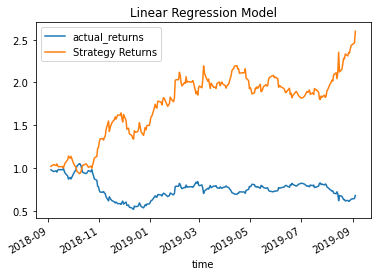

In [68]:
# Plot the actual returns versus the strategy returns
(1 + pred_df[['actual_returns', 'Strategy Returns']]).cumprod().plot(title = "Linear Regression Model")


In [ ]:
Building the Alpaca Trigger

In [69]:
# Filter the date index and close columns
signals_df = df.loc[:, ["close"]]
# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()
# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()
# Generate the fast and slow simple moving averages (sma_1 and sma_2 days, respectively)
signals_df[f'SMA_{sma_1}'] = signals_df['close'].rolling(window=sma_1).mean()
signals_df[f'SMA_{sma_2}'] = signals_df['close'].rolling(window=sma_2).mean()


In [70]:
# plotting SMAs
#plt.plot(signals_df['close'], label =f"{symbol} Share Price", color='lightgray')
#plt.plot(signals_df[f'SMA_{sma_1}'], label =f"SMA_{sma_1}", color='orange')
#plt.plot(signals_df[f'SMA_{sma_2}'], label =f"SMA_{sma_2}", color='purple')
#plt.legend(loc="upper left")
#plt.show

In [72]:
# Set the Signal column
signals_df["Signal"] = 0.0

# Generate the trading signal 1 or 0,
# where 0 is when the short SMA is less than (or crosses below) the long SMA
# where 1 is when the short SMA is greater than the long SMA,
signals_df["Signal"][sma_1:] = np.where(
    signals_df[f'SMA_{sma_1}'][sma_1:] < signals_df[f'SMA_{sma_2}'][sma_1:], 0.0, 1.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
signals_df["Buy/Sell"] = signals_df["Signal"].diff()

# Review the DataFrame
signals_df = signals_df.dropna()
signals_df.tail()

,close,Actual Returns,SMA_9,SMA_21,Signal,Buy/Sell
time,,,,,,
2021-07-08 00:00:00-04:00,12.8737,-0.008190,13.135489,13.227114,0.0,0.0
2021-07-09 00:00:00-04:00,13.1541,0.021781,13.135311,13.200167,0.0,0.0
2021-07-12 00:00:00-04:00,13.1100,-0.003353,13.158644,13.175881,0.0,0.0
2021-07-13 00:00:00-04:00,12.8900,-0.016781,13.136422,13.138024,0.0,0.0
2021-07-14 00:00:00-04:00,12.8100,-0.006206,13.064200,13.106595,0.0,0.0


In [73]:
# Visualize entry position relative to close price
entry = signals_df[signals_df["Buy/Sell"] == 1.0]["close"].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    label =f"{symbol} Share Price",
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = signals_df[signals_df["Buy/Sell"] == -1.0]["close"].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    label =f"{symbol} Share Price",
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[["close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    label =f"{symbol} Share Price",
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df[[f'SMA_{sma_1}', f'SMA_{sma_2}']].hvplot(
    ylabel='Price in $',
    label =f"{symbol} Share Price",
    width=1000,
    height=400
)




# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot

:Overlay
   .Curve.GE_Share_Price      :Curve   [time]   (close)
   .NdOverlay.GE_Share_Price  :NdOverlay   [Variable]
      :Curve   [time]   (value)
   .Scatter.GE_Share_Price.I  :Scatter   [time]   (close)
   .Scatter.GE_Share_Price.II :Scatter   [time]   (close)

In [74]:
signals_df['Buy/Sell'].value_counts()

 0.0    659
-1.0     20
 1.0     20
Name: Buy/Sell, dtype: int64

In [ ]:
Alpaca trade execution

In [76]:
# Set ticker and signal for live trade.
#signal=signals_df['Signal'][signals_df.index[-1]]
signal=signals_df['Buy/Sell'][signals_df.index[-1]]
print(f"Ticker symbol {symbol} Signal {signal}")

Ticker symbol GE Signal 0.0


In [77]:
# Create buy signal, num shares and ticker
if signal == 1.0:
    orderSide = "buy"
elif signal == -1.0:
    orderSide = "sell"
else:
    orderSide = "hold"
    

In [78]:
# Set the ticket symbol and the number of shares to buy
ticker = symbol
number_of_shares = 1

In [79]:
# Get final closing price
prices = api.get_barset(ticker, "1Min").df
limit_amount = prices[ticker]["close"][-1]
limit_amount

12.82

In [80]:
# Submit order
if orderSide == "hold":
    print(f"Holding {symbol} Stocks")
else:
    api.submit_order(
        symbol=ticker, 
        qty=number_of_shares, 
        side=orderSide, 
        time_in_force="gtc", 
        type="limit", 
        limit_price=limit_amount
    )
    print(f"Ticker symbol {symbol} Signal {signal}")

Holding GE Stocks


In [ ]:
orderSide